In [1]:
%load_ext autoreload
%autoreload 2

%cd ..

/home/rainorangelemon/Documents/complift/text-to-image


In [2]:
prompt_and_seeds = [
    ("a glass bottle with a message drifting past starfish", 2),
    ("a steaming teacup beside an open book and a candle", 5),
    ("A wooden ladder reaching into a treehouse under stars", 9),
    ("an old gramophone on a windowsill with falling autumn leaves", 7),
]

components = [
    ["a glass bottle", "a message", "starfish"],
    ["teacup", "an open book", "a candle"],
    ["a wooden ladder", "a treehouse", "stars"],
    ["an old gramophone", "a windowsill", "falling autumn leaves"],
]

prompts2titles = {
    "a glass bottle with a message drifting past starfish": "a glass bottle\nwith a message\ndrifting past starfish",
    "a steaming teacup beside an open book and a candle": "a steaming teacup\nbesides an open book\nand a candle",
    "an old gramophone on a windowsill with falling autumn leaves": "an old gramophone\non a windowsill with\nfalling autumn leaves",
    "A wooden ladder reaching into a treehouse under stars": "a wooden ladder\nreaching into \na treehouse\nunder stars",
}

def convert_prompt_to_title(prompt_idx):
    object0, object1, object2 = components[prompt_idx]
    title = prompts2titles[prompt_and_seeds[prompt_idx][0]]
    # title = title.replace("\\n", "\\\\")
    # title = title.replace(object0, r"\textcolor[HTML]{F44336}{" + object0 + r"}")
    # title = title.replace(object1, r"\textcolor[HTML]{FFC107}{" + object1 + r"}")
    # title = title.replace(object2, r"\textcolor[HTML]{4CAF50}{" + object2 + r"}")
    return rf'{title}'

In [ ]:
# %%capture # suppress output if needed

# this takes roughly 1 minute on a 4090 GPU
for prompt, seed in prompt_and_seeds:
    !python run.py --prompt "{prompt}" --seeds [{seed}] --sd_xl=True --run_standard_sd=True --save_intermediate_latent=True --output_path "outputs/mini_test"

# analyze logp, this takes roughly 20 minutes on a 4090 GPU
for prompt_and_seed, components in zip(prompt_and_seeds, components):
    prompt = prompt_and_seed[0]
    !python analyze_logp.py --prompt "{prompt}" --sd_xl True --n_samples 1000 --output_path outputs/mini_test --components "{components}"

In [10]:
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False

# Global constants
TITLE_FONTSIZE = 25
COLORBAR_FONTSIZE = 10
BORDER_LINEWIDTH = 10
COLORBAR_SIZE = "4%"
COLORBAR_PAD = 0.2
YLABEL_X_COORD = -0.52
YLABEL_Y_COORD = 0.5
HEATMAP_MIN_THRESHOLD = 1e-8

def plot_original_image(ax, idx: int, output_path: str, prompt_text: str):
    """Plot the original image with title and ylabel."""
    # Load and convert image to numpy array
    image = Image.open(f"{output_path}/{idx}.png")
    image_array = np.array(image)

    # Display image without interpolation to maintain sharpness
    im = ax[0].imshow(image_array, interpolation='nearest')
    title = "Image (1024x1024)"
    ax[0].set_title(title, fontsize=TITLE_FONTSIZE)

    # Set aspect to 'auto' to fill the entire subplot
    ax[0].set_aspect('auto')

def plot_latents(ax, latents: torch.Tensor):
    """Plot the latent representations."""
    im = ax[1].imshow(latents.cpu().numpy(), cmap="gray", interpolation='nearest')
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size=COLORBAR_SIZE, pad=COLORBAR_PAD)
    cbar = plt.colorbar(im, cax=cax, format="%.1f")
    cbar.ax.tick_params(labelsize=COLORBAR_FONTSIZE)
    cbar.ax.yaxis.offsetText.set_fontsize(COLORBAR_FONTSIZE)
    title = "Latent (128x128)"
    ax[1].set_title(title, fontsize=TITLE_FONTSIZE)

    # Set aspect to 'auto' to fill the entire subplot
    ax[1].set_aspect('auto')

def plot_heatmap(ax, heatmap: torch.Tensor, border_color: str, threshold: float):
    """Plot the heatmap with colorbar and border."""
    if heatmap.relu().cpu().numpy().max() > HEATMAP_MIN_THRESHOLD:
        im = ax.imshow(heatmap.relu().cpu().numpy(), cmap="turbo", interpolation='nearest')
    else:
        im = ax.imshow(heatmap.relu().cpu().numpy(), cmap="turbo", vmin=0, vmax=HEATMAP_MIN_THRESHOLD, interpolation='nearest')

    # Add colored border to the plot
    for spine in ax.spines.values():
        spine.set_linewidth(BORDER_LINEWIDTH)
        spine.set_edgecolor(border_color)
        spine.set_visible(True)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=COLORBAR_SIZE, pad=COLORBAR_PAD)

    if heatmap.relu().cpu().numpy().max() <= HEATMAP_MIN_THRESHOLD:
        cbar = plt.colorbar(im, cax=cax, ticks=[0])
        cbar.ax.tick_params(labelsize=COLORBAR_FONTSIZE)
        cbar.ax.yaxis.get_offset_text().set_fontsize(COLORBAR_FONTSIZE)
    else:
        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=COLORBAR_FONTSIZE)
        cbar.ax.yaxis.get_offset_text().set_fontsize(COLORBAR_FONTSIZE)
        cbar.ax.yaxis.set_offset_position('left')

    ax.set_title(f"#Activated Pixels: {(heatmap > threshold).sum().item()}",
                fontsize=TITLE_FONTSIZE)

    # Set aspect to 'auto' to fill the entire subplot
    ax.set_aspect('auto')

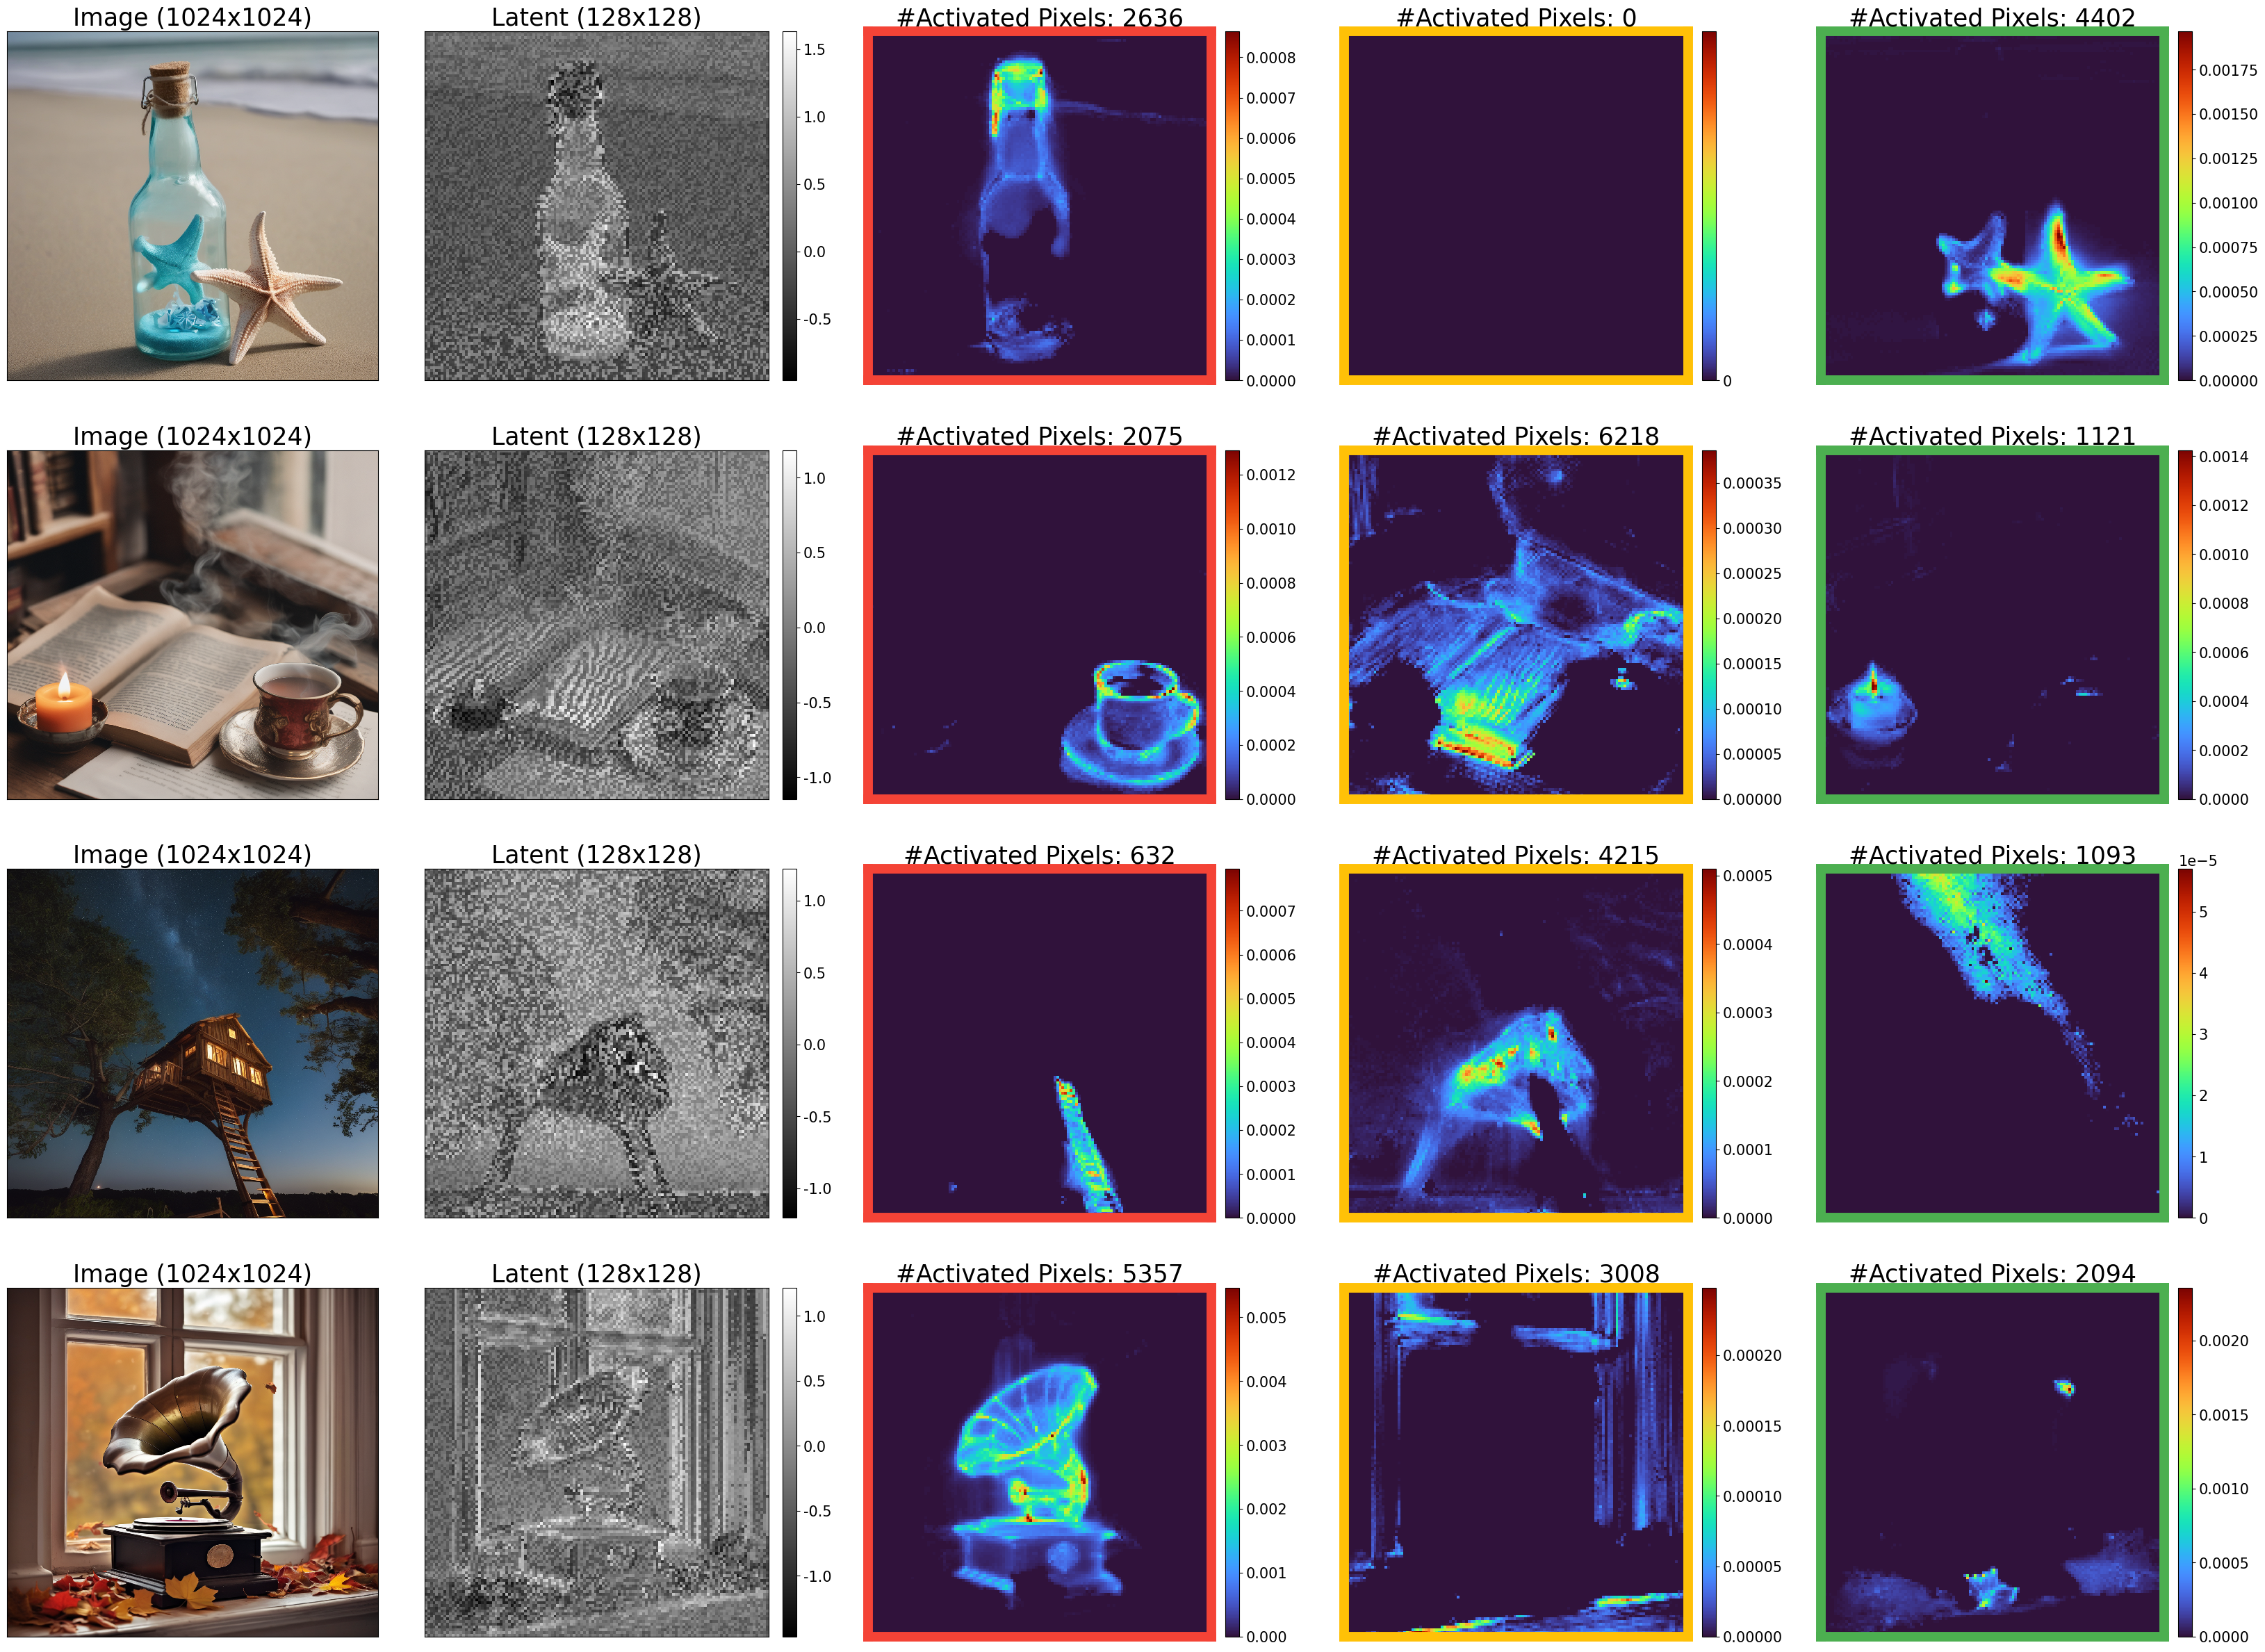

In [18]:
import torch
from PIL import Image

threshold = 1e-5
GOOGLE_RED = "#F44336"
GOOGLE_BLUE = "#2196F3"
GOOGLE_GREEN = "#4CAF50"
GOOGLE_YELLOW = "#FFC107"

plt.clf()
plt.close("all")
fig, ax = plt.subplots(len(prompt_and_seeds), len(components[0]) + 2, figsize=(40, 30))
gs = fig.add_gridspec(
    len(prompt_and_seeds),
    len(components[0]) + 2,
    hspace=0.18,
    wspace=0.2,
    left=0.4,
    right=0.95,
)

# Adjust subplot positions
for i in range(len(prompt_and_seeds)):
    positions = [
        [0, 0],
        [-0.01, 0],
        [-0.011, 0],
        [0, 0],
        [0.011, 0]
    ]
    for col, (x_offset, y_offset) in enumerate(positions):
        pos = ax[i,col].get_position()
        ax[i,col].set_position([
            pos.x0 + x_offset,
            pos.y0 + y_offset,
            pos.width,
            pos.height
        ])

for idx, (prompt_and_seed, comp_list) in enumerate(zip(prompt_and_seeds, components)):
    prompt, seed = prompt_and_seed
    output_path = f"outputs/mini_test/{prompt}"

    # Plot original image
    prompt_text = convert_prompt_to_title(idx)
    plot_original_image(ax[idx], seed, output_path, prompt_text)

    # Plot latents
    latents = torch.load(f"outputs/mini_test/{prompt}/{seed}_lift_results.pt", weights_only=True)["latents"].mean(dim=(0, 1))
    plot_latents(ax[idx], latents)

    # Load and process scores
    scores = torch.load(f"{output_path}/{seed}_score_results.pt", weights_only=True)
    score_uncond = scores[:, -1]
    score_composed = scores[:, 0]

    # Plot component heatmaps
    for comp_idx, component in enumerate(comp_list):
        component_score = scores[:, comp_idx + 1]
        mse = (score_composed - component_score).pow(2).mean(dim=(1, 2))

        other_scores = [scores[:, i] for i in range(len(scores[0]))
                       if i not in [comp_idx + 1, 0, len(scores[0]) - 1]]
        other_mse = torch.stack([
            (score_composed - other_score).pow(2).mean(dim=(1, 2))
            for other_score in other_scores
        ])
        min_other_mse = other_mse.min(dim=0).values
        lift = (min_other_mse - mse)[0]

        plot_heatmap(
            ax[idx][comp_idx + 2],
            lift - threshold,
            border_color = [GOOGLE_RED, GOOGLE_YELLOW, GOOGLE_GREEN][comp_idx],
            threshold=threshold
        )

plt.savefig("figures/component_analysis.png", bbox_inches='tight', pad_inches=0.5)